## Import libraries

In [33]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind
import nbformat
from nbformat.v4 import new_notebook, new_markdown_cell, new_code_cell
import os

## Load your CSV File

In [6]:

df = pd.read_csv(r'C:\Users\asus\Desktop\major_project\Traffics\traffic_data1.csv')  # replace with your file path
df.head()

,timestamp,location,vehicle_count,heavy_vehicle_count,light_vehicle_count,avg_speed,avg_speed_heavy,avg_speed_light,speed_variance,traffic_density,congestion_index,congestion_level,travel_time_minutes,weather,rainfall_mm,event,day_of_week,is_weekend,hour_of_day
0,01-09-2025 00:00,MG Road,128,34,94,53.551270,50.092965,50.053432,8.2,0.64,6.4,Medium,5.6,Rainy,0.9,0,0,0,0
1,01-09-2025 01:00,MG Road,128,18,110,41.504344,44.002989,61.629289,2.7,0.64,6.4,Medium,7.2,Clear,0.0,0,0,0,1
2,01-09-2025 02:00,MG Road,123,32,91,44.588762,43.070101,57.200174,5.1,0.61,6.1,Medium,6.7,Clear,0.0,0,0,0,2
3,01-09-2025 03:00,MG Road,177,25,152,38.129139,42.713476,49.362042,6.9,0.89,8.9,High,7.9,Rainy,17.9,0,0,0,3
4,01-09-2025 04:00,MG Road,114,17,97,44.087356,42.515568,61.886734,3.7,0.57,5.7,Medium,6.8,Rainy,11.3,0,0,0,4


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            4320 non-null   object 
 1   location             4320 non-null   object 
 2   vehicle_count        4320 non-null   int64  
 3   heavy_vehicle_count  4320 non-null   int64  
 4   light_vehicle_count  4320 non-null   int64  
 5   avg_speed            4320 non-null   float64
 6   avg_speed_heavy      4320 non-null   float64
 7   avg_speed_light      4320 non-null   float64
 8   speed_variance       4320 non-null   float64
 9   traffic_density      4320 non-null   float64
 10  congestion_index     4320 non-null   float64
 11  congestion_level     4320 non-null   object 
 12  travel_time_minutes  4320 non-null   float64
 13  weather              4320 non-null   object 
 14  rainfall_mm          4320 non-null   float64
 15  event                4320 non-null   i

In [8]:
# Convert timestamp to datetime

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M')
df['date'] = df['timestamp'].dt.date

### # Quick overview

In [9]:

rint("Rows, Columns:", df.shape)
print("\nColumns and types:\n", df.dtypes)
print("\nFirst 5 rows:")
display(df.head())

Rows, Columns: (4320, 20)

Columns and types:
 timestamp              datetime64[ns]
location                       object
vehicle_count                   int64
heavy_vehicle_count             int64
light_vehicle_count             int64
avg_speed                     float64
avg_speed_heavy               float64
avg_speed_light               float64
speed_variance                float64
traffic_density               float64
congestion_index              float64
congestion_level               object
travel_time_minutes           float64
weather                        object
rainfall_mm                   float64
event                           int64
day_of_week                     int64
is_weekend                      int64
hour_of_day                     int64
date                           object
dtype: object

First 5 rows:


,timestamp,location,vehicle_count,heavy_vehicle_count,light_vehicle_count,avg_speed,avg_speed_heavy,avg_speed_light,speed_variance,traffic_density,congestion_index,congestion_level,travel_time_minutes,weather,rainfall_mm,event,day_of_week,is_weekend,hour_of_day,date
0,2025-09-01 00:00:00,MG Road,128,34,94,53.551270,50.092965,50.053432,8.2,0.64,6.4,Medium,5.6,Rainy,0.9,0,0,0,0,2025-09-01
1,2025-09-01 01:00:00,MG Road,128,18,110,41.504344,44.002989,61.629289,2.7,0.64,6.4,Medium,7.2,Clear,0.0,0,0,0,1,2025-09-01
2,2025-09-01 02:00:00,MG Road,123,32,91,44.588762,43.070101,57.200174,5.1,0.61,6.1,Medium,6.7,Clear,0.0,0,0,0,2,2025-09-01
3,2025-09-01 03:00:00,MG Road,177,25,152,38.129139,42.713476,49.362042,6.9,0.89,8.9,High,7.9,Rainy,17.9,0,0,0,3,2025-09-01
4,2025-09-01 04:00:00,MG Road,114,17,97,44.087356,42.515568,61.886734,3.7,0.57,5.7,Medium,6.8,Rainy,11.3,0,0,0,4,2025-09-01


## # Summary statistics for numeric columns

In [10]:

print("\nNumeric summary:")
display(df.describe())


Numeric summary:


,timestamp,vehicle_count,heavy_vehicle_count,light_vehicle_count,avg_speed,avg_speed_heavy,avg_speed_light,speed_variance,traffic_density,congestion_index,travel_time_minutes,rainfall_mm,event,day_of_week,is_weekend,hour_of_day
count,4320,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000
mean,2025-09-15 23:29:59.999999744,170.004630,33.489815,136.514815,42.822900,46.659571,51.333240,5.971157,0.849606,8.258958,7.191667,2.019329,0.089583,2.833333,0.266667,11.500000
min,2025-09-01 00:00:00,57.000000,6.000000,41.000000,18.591148,27.172809,27.253614,2.000000,0.280000,2.800000,4.300000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2025-09-08 11:45:00,141.000000,23.000000,112.000000,38.201806,43.056519,47.093182,4.000000,0.700000,7.200000,6.300000,0.000000,0.000000,1.000000,0.000000,5.750000
50%,2025-09-15 23:30:00,169.000000,32.000000,137.000000,42.908991,46.683486,51.277522,6.000000,0.840000,8.600000,7.000000,0.000000,0.000000,3.000000,0.000000,11.500000
75%,2025-09-23 11:15:00,203.000000,43.000000,163.000000,47.327341,50.177202,55.588672,7.900000,1.010000,10.000000,7.900000,0.000000,0.000000,5.000000,1.000000,17.250000
max,2025-09-30 23:00:00,269.000000,77.000000,238.000000,69.750394,64.096378,72.508226,10.000000,1.340000,10.000000,16.100000,20.000000,1.000000,6.000000,1.000000,23.000000
std,NaN,45.571181,13.720354,37.601107,6.741043,5.190969,6.287949,2.299071,0.227652,1.817956,1.221083,4.754698,0.285617,2.034661,0.442268,6.922988


## # 1) Distribution of vehicle_count (histogram)

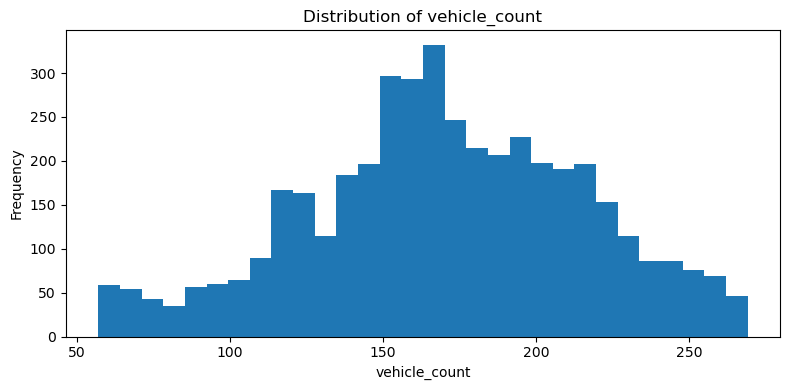

In [11]:

plt.figure(figsize=(8,4))
plt.hist(df['vehicle_count'], bins=30)
plt.title("Distribution of vehicle_count")
plt.xlabel("vehicle_count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## # 2) Daily total traffic trend (time series)

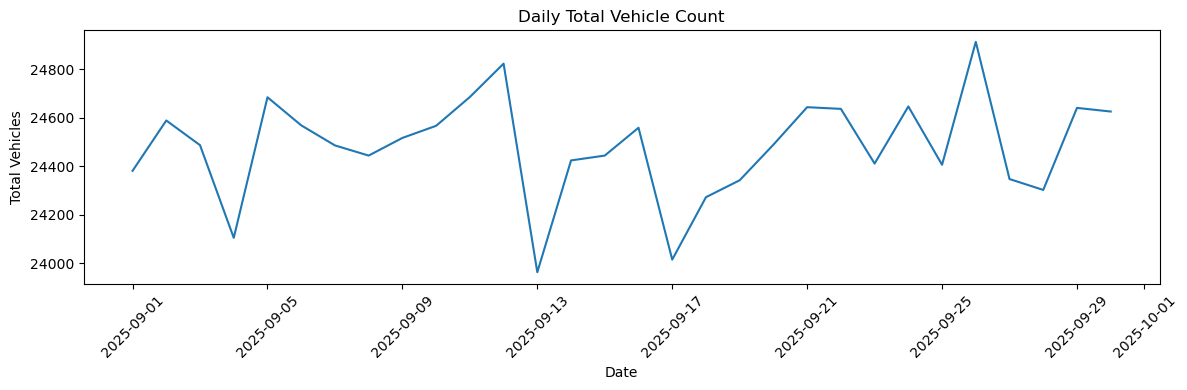

In [12]:

daily = df.groupby('date')['vehicle_count'].sum().reset_index()
plt.figure(figsize=(12,4))
plt.plot(daily['date'], daily['vehicle_count'])
plt.title("Daily Total Vehicle Count")
plt.xlabel("Date")
plt.ylabel("Total Vehicles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:

df['is_peak_hour'] = df['hour_of_day'].apply(lambda x: 1 if 7 <= x <= 10 or 17 <= x <= 19 else 0)
df['part_of_day'] = df['hour_of_day'].apply(lambda x: 'Morning' if 5<=x<12 else 
                                           ('Afternoon' if 12<=x<17 else 
                                            ('Evening' if 17<=x<21 else 'Night')))
df['heavy_ratio'] = df['heavy_vehicle_count'] / df['vehicle_count']
df['light_ratio'] = df['light_vehicle_count'] / df['vehicle_count']
df['speed_diff'] = df['avg_speed_light'] - df['avg_speed_heavy']

## Average Vehicle Count per Hour by Location

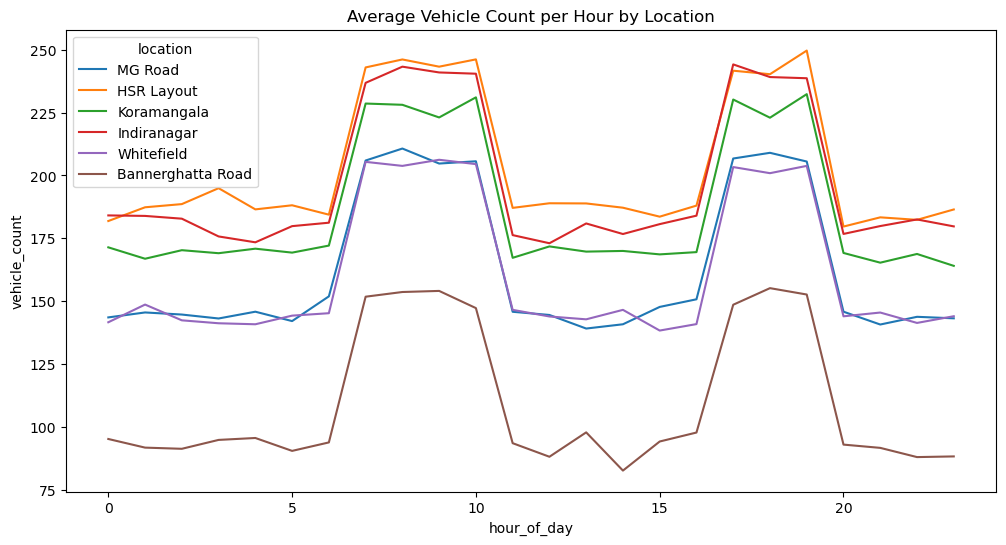

In [34]:

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='hour_of_day', y='vehicle_count', hue='location', ci=None)
plt.title('Average Vehicle Count per Hour by Location')
plt.show()

## Congestion Level Distribution by Location

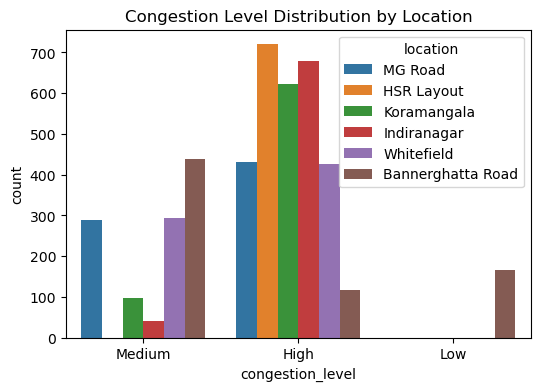

In [35]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='congestion_level', hue='location')
plt.title('Congestion Level Distribution by Location')
plt.show()

## Traffic Density vs Congestion Index

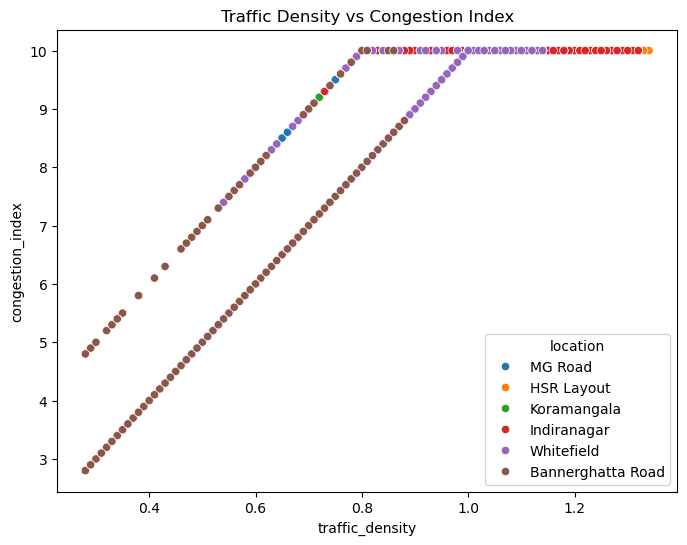

In [36]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='traffic_density', y='congestion_index', hue='location')
plt.title('Traffic Density vs Congestion Index')
plt.show()

## Vehicle Count by Weather Condition

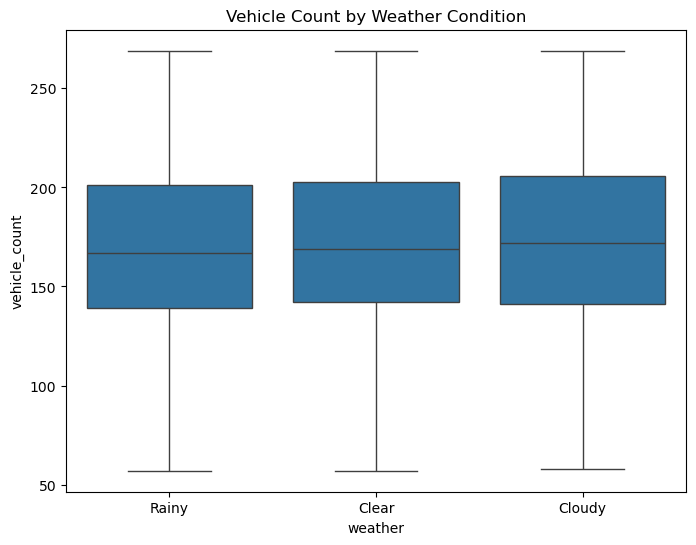

In [37]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='weather', y='vehicle_count')
plt.title('Vehicle Count by Weather Condition')
plt.show()

## Average Vehicle Count: Peak vs Non-Peak Hours

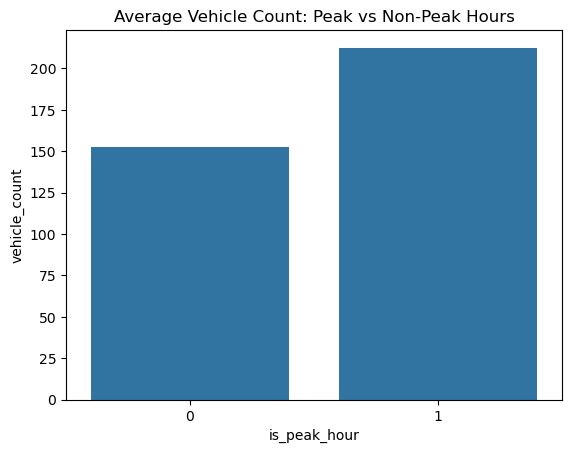

In [40]:
peak_df = df.groupby('is_peak_hour')['vehicle_count'].mean().reset_index()
sns.barplot(data=peak_df, x='is_peak_hour', y='vehicle_count')
plt.title('Average Vehicle Count: Peak vs Non-Peak Hours')
plt.show()

## Average vehicle_count by location (top 10)

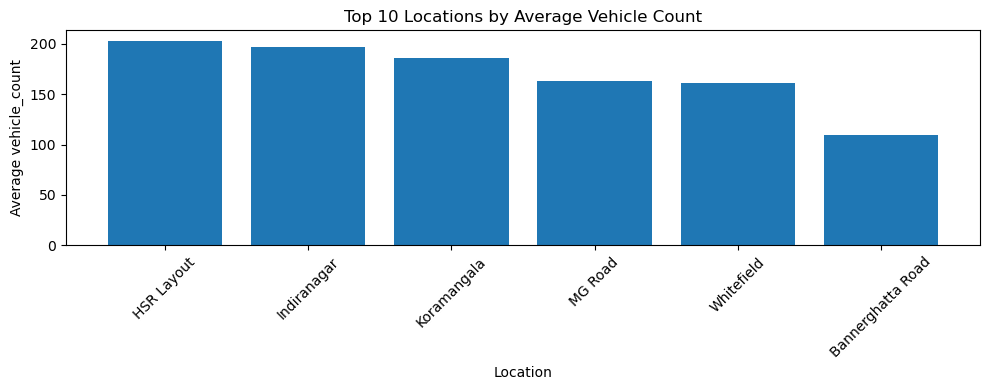

In [13]:

loc_avg = df.groupby('location')['vehicle_count'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,4))
plt.bar(loc_avg.index, loc_avg.values)
plt.title("Top 10 Locations by Average Vehicle Count")
plt.xlabel("Location")
plt.ylabel("Average vehicle_count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Congestion level counts (bar)

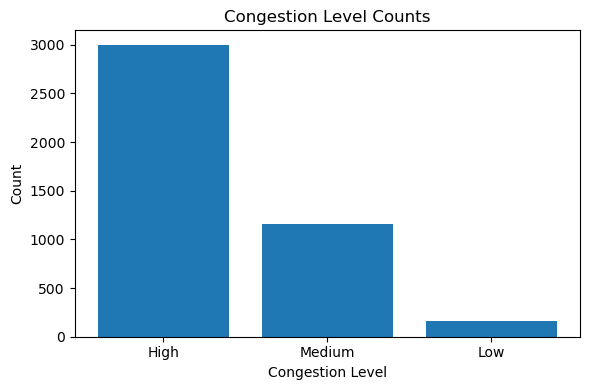

In [14]:

cong_counts = df['congestion_level'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(cong_counts.index, cong_counts.values)
plt.title("Congestion Level Counts")
plt.xlabel("Congestion Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Line Chart: Rainfall vs Congestion Trend (sample first 200 records for clarity)

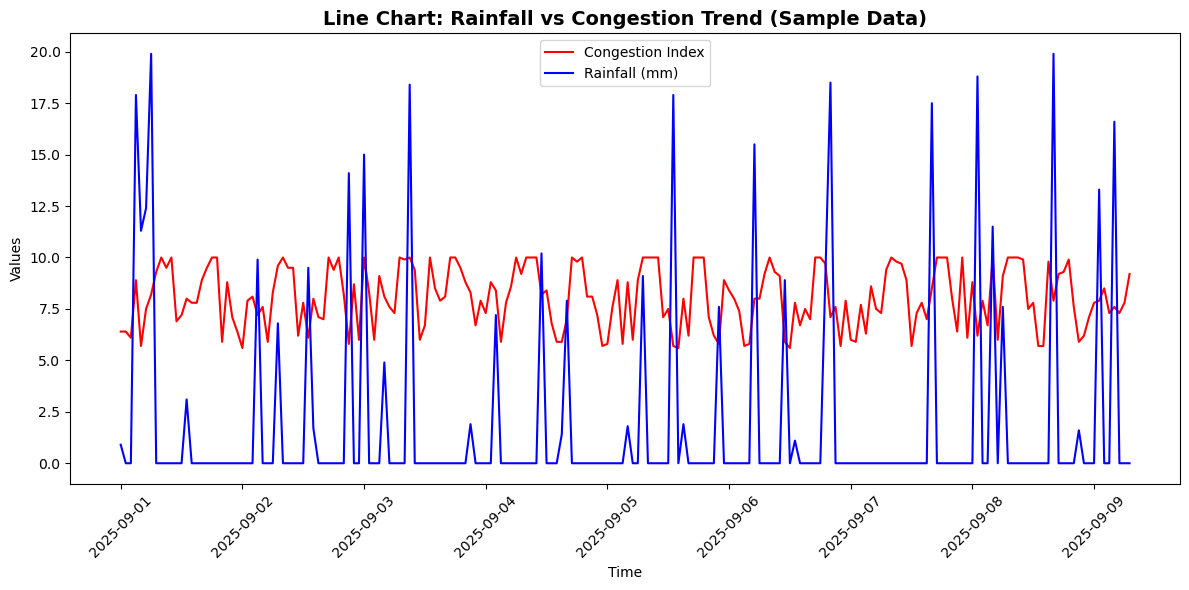

In [41]:

plt.figure(figsize=(12, 6))
plt.plot(df["timestamp"][:200], df["congestion_index"][:200], label="Congestion Index", color="red")
plt.plot(df["timestamp"][:200], df["rainfall_mm"][:200], label="Rainfall (mm)", color="blue")
plt.xticks(rotation=45)
plt.title("Line Chart: Rainfall vs Congestion Trend (Sample Data)", fontsize=14, weight="bold")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.tight_layout()
plt.show()

## Correlation matrix (numeric columns)

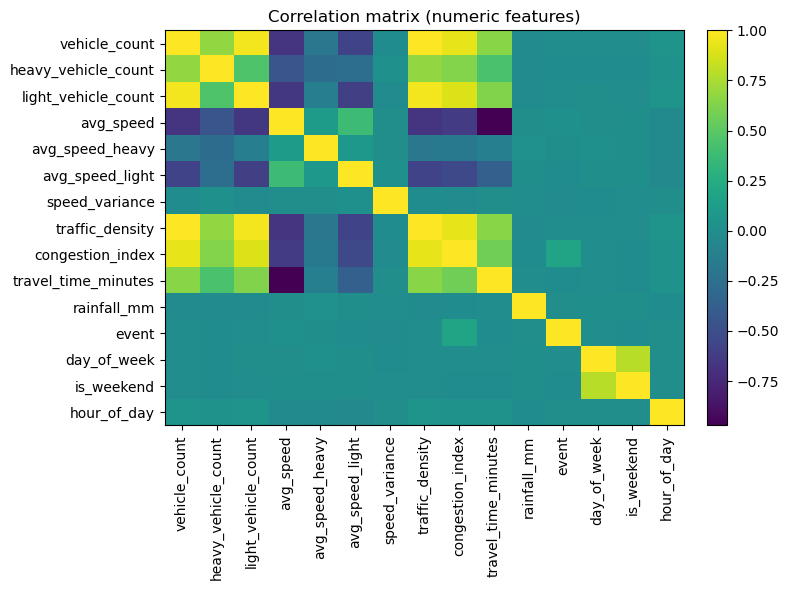

In [15]:

numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(8,6))
im = plt.imshow(corr, aspect='auto', interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Correlation matrix (numeric features)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

## Top 5 dates with highest total traffic

In [16]:

top_days = daily.sort_values(by='vehicle_count', ascending=False).head(5)
print("\nTop 5 dates with highest total vehicle_count:")
display(top_days)


Top 5 dates with highest total vehicle_count:


,date,vehicle_count
25,2025-09-26,24914
11,2025-09-12,24824
10,2025-09-11,24686
4,2025-09-05,24685
23,2025-09-24,24647


## Location-wise peak hour (for top 5 locations by total traffic)

In [17]:

top_locations = df.groupby('location')['vehicle_count'].sum().sort_values(ascending=False).head(5).index.tolist()
peak_hours = {}
for loc in top_locations:
    temp = df[df['location']==loc].groupby('hour_of_day')['vehicle_count'].mean()
    peak_hours[loc] = int(temp.idxmax())
    
print("\nPeak hour (avg vehicle_count) for top 5 locations:")
for k,v in peak_hours.items():
    print(f"{k}: {v}:00")


Peak hour (avg vehicle_count) for top 5 locations:
HSR Layout: 19:00
Indiranagar: 17:00
Koramangala: 19:00
MG Road: 8:00
Whitefield: 9:00



Congestion by rainfall bins:
    rain_bin      mean  median  count
0    NoRain  8.286516     8.7   3441
1     Light  7.864000     8.0    100
2  Moderate  8.181009     8.4    337
3     Heavy  8.193213     8.5    442


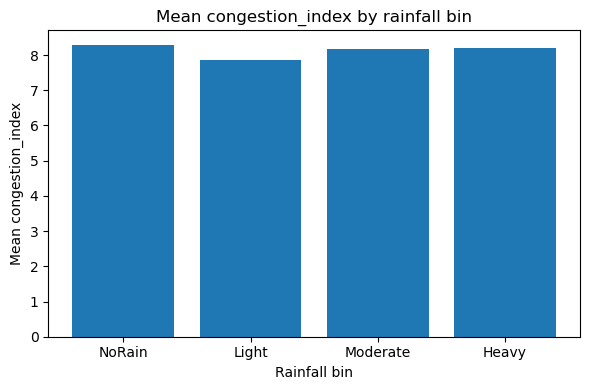

In [21]:
# Rainfall bins impact
if 'rainfall_mm' in df.columns and 'congestion_index' in df.columns:
    df['rain_bin'] = pd.cut(df['rainfall_mm'], bins=[-0.01,0,2,10,1000], labels=['NoRain','Light','Moderate','Heavy'])
    rain_group = df.groupby('rain_bin')['congestion_index'].agg(['mean','median','count']).reset_index()
    print("\nCongestion by rainfall bins:\n", rain_group)
    plt.figure(figsize=(6,4))
    plt.bar(rain_group['rain_bin'].astype(str), rain_group['mean'])
    plt.title("Mean congestion_index by rainfall bin")
    plt.xlabel("Rainfall bin")
    plt.ylabel("Mean congestion_index")
    plt.tight_layout()
    plt.show()

## Event impact analysis (event vs non-event)


Congestion (event vs non-event):
    is_event      mean  median  count
0      True  8.258958     8.6   4320

Not enough samples for robust t-test.


C:\Users\asus\AppData\Local\Temp\ipykernel_9440\1082470437.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cong_non.values, cong_event.values], labels=['Non-Event','Event'])


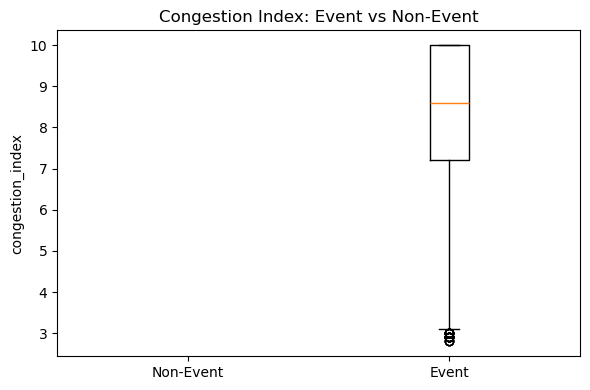

In [23]:

# ---------------------------
if 'event' in df.columns and 'congestion_index' in df.columns:
    df['is_event'] = (~df['event'].isnull()) & (df['event'].astype(str).str.strip().str.lower() != 'none') & (df['event'].astype(str).str.strip() != '')
    ev_group = df.groupby('is_event')['congestion_index'].agg(['mean','median','count']).reset_index()
    print("\nCongestion (event vs non-event):\n", ev_group)
    
    # t-test for difference
    cong_event = df[df['is_event']==True]['congestion_index']
    cong_non = df[df['is_event']==False]['congestion_index']
    if len(cong_event) > 5 and len(cong_non) > 5:
        tstat, pval = ttest_ind(cong_event, cong_non, equal_var=False)
        print(f"\nT-test: t={tstat:.3f}, p={pval:.4f}")
    else:
        print("\nNot enough samples for robust t-test.")
    
    # boxplot (matplotlib) - event vs non-event
    plt.figure(figsize=(6,4))
    plt.boxplot([cong_non.values, cong_event.values], labels=['Non-Event','Event'])
    plt.title("Congestion Index: Event vs Non-Event")
    plt.ylabel("congestion_index")
    plt.tight_layout()
    plt.show()

##  Predictive modeling (congestion_index regression)

In [44]:

# ---------------------------
model_report = {}
model_feature_importances = None
model_metrics = {}
model_preds_df = pd.DataFrame()

if 'congestion_index' in df.columns:
    modelling_df = df.copy()
    # Select features (manual selection to avoid leakage)
    features = ['hour_of_day','is_weekend','rainfall_mm','vehicle_count','heavy_vehicle_count','light_vehicle_count','avg_speed','traffic_density']
    # Some categorical features: location (limit to top N), event (binary), weather (top categories)
    # Encode location: keep top 10 as dummies, rest as 'Other'
    topN = 10
    top_locs = modelling_df['location'].value_counts().nlargest(topN).index.tolist()
    modelling_df['location_enc'] = modelling_df['location'].where(modelling_df['location'].isin(top_locs), 'Other')
    # One-hot for location_enc (will create df later)
    modelling_df['event_flag'] = modelling_df['is_event'].astype(int) if 'is_event' in modelling_df.columns else 0
    # One-hot for weather top categories (top 5)
    top_weather = modelling_df['weather'].value_counts().nlargest(5).index.tolist()
    modelling_df['weather_enc'] = modelling_df['weather'].where(modelling_df['weather'].isin(top_weather), 'Other')
    
    # Construct X, y
    X_num = modelling_df[features].copy()
    # fill na numeric with 0
    X_num = X_num.fillna(0)
    # One-hot encode location_enc and weather_enc, and include event_flag
    X_cat = pd.get_dummies(modelling_df[['location_enc','weather_enc']], drop_first=True)
    X = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True), modelling_df[['event_flag']].reset_index(drop=True)], axis=1)
    y = modelling_df['congestion_index'].values
    
    # Time-based train-test split: earliest 80% train, latest 20% test
    split_idx = int(len(modelling_df)*0.8)
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    print("\nModeling shapes:", X_train.shape, X_test.shape)
    
    # Standardize numeric columns for GradientBoosting optional (RandomForest not needed)
    num_cols = ['hour_of_day','is_weekend','rainfall_mm','vehicle_count','heavy_vehicle_count','light_vehicle_count','avg_speed','traffic_density']
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])
    
    # RandomForestRegressor
    rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rfr.fit(X_train, y_train)
    rfr_preds = rfr.predict(X_test)
    rfr_mae = mean_absolute_error(y_test, rfr_preds)
    rfr_rmse = mean_squared_error(y_test, rfr_preds, squared=False)
    rfr_r2 = r2_score(y_test, rfr_preds)
    model_metrics['RandomForest'] = {'MAE': rfr_mae, 'RMSE': rfr_rmse, 'R2': rfr_r2}
    print("\nRandomForest metrics:", model_metrics['RandomForest'])
    
    # GradientBoostingRegressor (using scaled numeric inputs)
    gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
    gbr.fit(X_train_scaled, y_train)
    gbr_preds = gbr.predict(X_test_scaled)
    gbr_mae = mean_absolute_error(y_test, gbr_preds)
    gbr_rmse = mean_squared_error(y_test, gbr_preds, squared=False)
    gbr_r2 = r2_score(y_test, gbr_preds)
    model_metrics['GradientBoosting'] = {'MAE': gbr_mae, 'RMSE': gbr_rmse, 'R2': gbr_r2}
    print("GradientBoosting metrics:", model_metrics['GradientBoosting'])
    
    # Feature importances from RandomForest (and from GBR)
    feat_importances = pd.Series(rfr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    feat_importances_gbr = pd.Series(gbr.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)
    model_feature_importances = {'RandomForest': feat_importances, 'GradientBoosting': feat_importances_gbr}
    
    # Save predictions + actuals for review
    model_preds_df = pd.DataFrame({
        'timestamp': modelling_df['timestamp'].iloc[split_idx:].values,
        'location': modelling_df['location'].iloc[split_idx:].values,
        'actual_congestion': y_test,
        'rfr_pred': rfr_preds,
        'gbr_pred': gbr_preds
    })
    
   


   
    


Modeling shapes: (3456, 16) (864, 16)

RandomForest metrics: {'MAE': 0.9232662037037014, 'RMSE': 1.3643286844669251, 'R2': 0.49275478740240886}
GradientBoosting metrics: {'MAE': 0.8670706020448733, 'RMSE': 1.2984033607954741, 'R2': 0.5405913177682122}


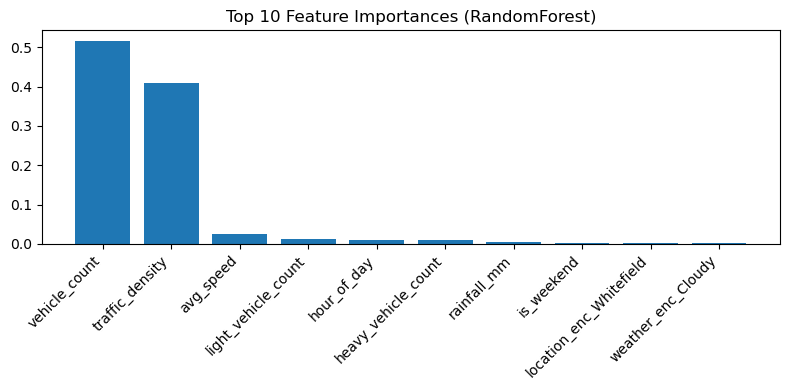

In [45]:
# Plot top 10 feature importances (RandomForest)
topk = feat_importances.head(10)
plt.figure(figsize=(8,4))
plt.bar(topk.index.astype(str), topk.values)
plt.title("Top 10 Feature Importances (RandomForest)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()           

## Clustering locations by hourly profile (k-means)


Cluster counts: {0: 3, 1: 1, 2: 2}


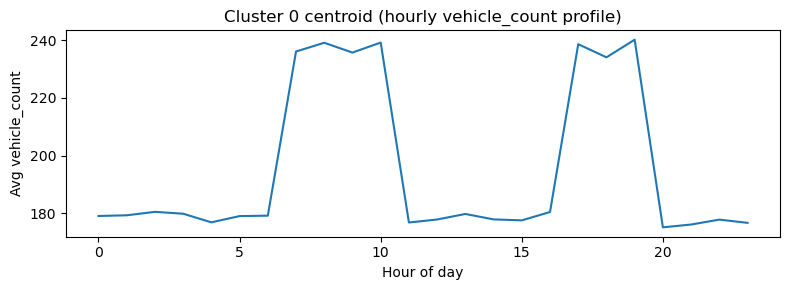

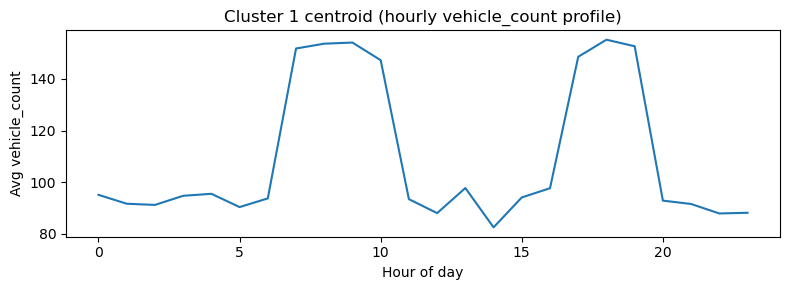

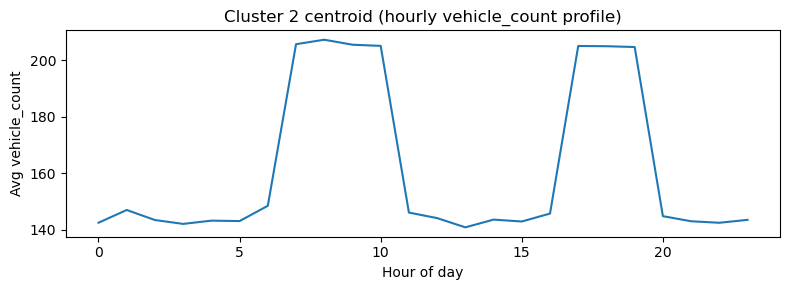

In [31]:

# ---------------------------
# Pivot: location x hour -> mean vehicle_count at each hour
hourly_profile = df.groupby(['location','hour_of_day'])['vehicle_count'].mean().reset_index()
pivot = hourly_profile.pivot(index='location', columns='hour_of_day', values='vehicle_count').fillna(0)
# Standardize
scaler_p = StandardScaler()
pivot_scaled = scaler_p.fit_transform(pivot.values)
# Choose k (3) for demonstration
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(pivot_scaled)
pivot['cluster'] = clusters
cluster_centers = scaler_p.inverse_transform(kmeans.cluster_centers_)

# Display cluster assignment counts
cluster_counts = pd.Series(clusters).value_counts().sort_index()
print("\nCluster counts:", cluster_counts.to_dict())




# Plot cluster centroids (mean hourly profile per cluster)
for ci in range(k):
    plt.figure(figsize=(8,3))
    centroid = cluster_centers[ci]
    plt.plot(range(24), centroid)
    plt.title(f"Cluster {ci} centroid (hourly vehicle_count profile)")
    plt.xlabel("Hour of day")
    plt.ylabel("Avg vehicle_count")
    plt.tight_layout()
    plt.show()